# Detailed pvlib report

In [1]:
LATITUDE = 48.77
LONGITUDE = 9.18
LOCATION = 'Stuttgart'
TIMEZONE = 'Etc/GMT-1'
ALTITUDE = 400
ALBEDO = 0.2 # Standard is 0.25. Why?

# -20.9   ,      55.5, 'St-Denis, La Réunion'     ,      100, 'Etc/GMT-4')

In [2]:
AZIMUTH = 180
TILT = 25

In [3]:
#TODO: Get timezone automatically
#TODO: Add requirements.txt
#TODO: Define functions each time, with only the strictly required parameters

# Enable caching

~~~
pip install requests-cache
~~~

In [4]:
# Not required. Avoids downloading same data over and over again:
import requests_cache
requests_cache.install_cache('pvgis_requests_cache', backend='sqlite')

# Get weather
~~~
pip install pvlib
~~~

In [5]:
from pvlib.iotools import pvgis

In [6]:
weather, _, info, _ = pvgis.get_pvgis_tmy(LATITUDE, LONGITUDE, map_variables=True)

In [7]:
weather_source = '%s (%d - %d)' % (info['meteo_data']['radiation_db'],
                                   info['meteo_data']['year_min'],
                                   info['meteo_data']['year_max'])
latitude_NS = '%.1f°%s' % (abs(LATITUDE), 'N' if LATITUDE > 0 else 'S')
longitude_EW = '%.1f°%s' % (abs(LONGITUDE), 'E' if LONGITUDE > 0 else 'W')

In [8]:
# Rename columns from PVGIS TMY in order to define the required data.
weather = weather.rename(columns={'G(h)': 'ghi',
                                  'Gb(n)': 'dni',
                                  'Gd(h)': 'dhi',
                                  'T2m': 'temp_air',
                                  'WS10m': 'wind_speed' # Does it make sense to use wind speed from 10m height?
                                  })
weather

temp_air  relative_humidity  ghi  dni  dhi   IR(h)  \
time(UTC)                                                                       
2016-01-01 00:00:00+00:00      2.70              96.70  0.0  0.0  0.0  292.75   
2016-01-01 01:00:00+00:00      3.26              97.01  0.0  0.0  0.0  299.49   
2016-01-01 02:00:00+00:00      3.83              97.32  0.0  0.0  0.0  306.23   
2016-01-01 03:00:00+00:00      4.39              97.62  0.0  0.0  0.0  312.97   
2016-01-01 04:00:00+00:00      4.96              97.93  0.0  0.0  0.0  319.71   
...                             ...                ...  ...  ...  ...     ...   
2007-12-31 19:00:00+00:00     -0.12              95.16  0.0  0.0  0.0  259.05   
2007-12-31 20:00:00+00:00      0.45              95.47  0.0  0.0  0.0  265.79   
2007-12-31 21:00:00+00:00      1.01              95.78  0.0  0.0  0.0  272.53   
2007-12-31 22:00:00+00:00      1.57              96.09  0.0  0.0  0.0  279.27   
2007-12-31 23:00:00+00:00      2.14              96.39  0.0  0.0  0.0  286.01   

                           wind_speed  wind_direction  pressure  
time(UTC)                                                        
2016-01-01 00:00:00+00:00        1.06           219.0   99358.0  
2016-01-01 01:00:00+00:00        1.05           228.0   99374.0  
2016-01-01 02:00:00+00:00        1.03           238.0   99390.0  
2016-01-01 03:00:00+00:00        1.01           222.0   99383.0  
2016-01-01 04:00:00+00:00        0.99           207.0   99377.0  
...                               ...             ...       ...  
2007-12-31 19:00:00+00:00        1.16           248.0   99586.0  
2007-12-31 20:00:00+00:00        1.14           246.0   99574.0  
2007-12-31 21:00:00+00:00        1.12           248.0   99561.0  
2007-12-31 22:00:00+00:00        1.10           249.0   99548.0  
2007-12-31 23:00:00+00:00        1.08           251.0   99535.0  

[8760 rows x 9 columns]

In [9]:
# Force all dates to be from the same year
COERCE_YEAR = 2019
weather.index = weather.index.map(lambda dt: dt.replace(year=COERCE_YEAR))

# Check and display weather

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.rcParams['figure.figsize'] = [15, 10]

## Ambient temperature

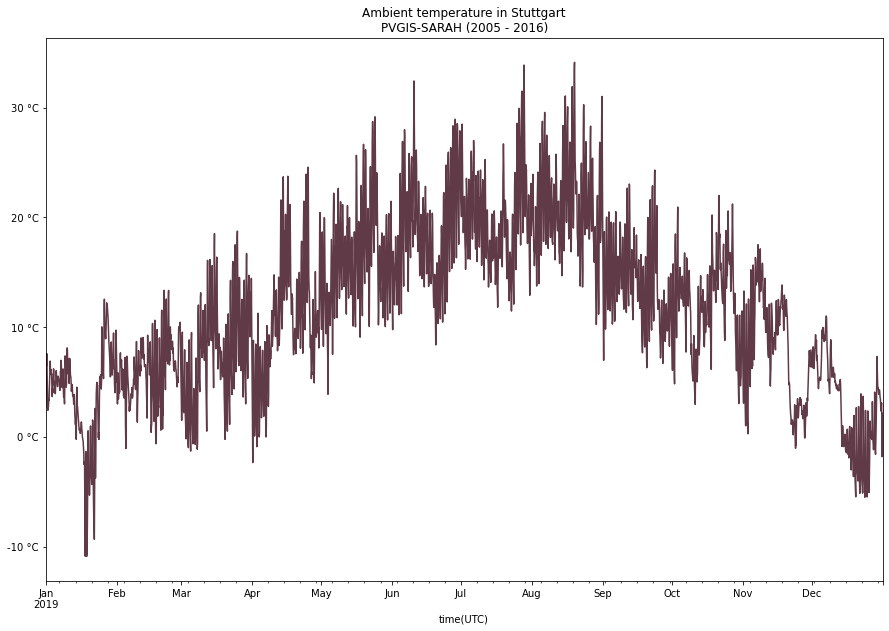

In [11]:
weather.temp_air.plot(title='Ambient temperature in %s\n%s' % (LOCATION, weather_source), color='#603a47')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%d °C'))

In [12]:
print("Average temperature in %s : %.1f °C" % (LOCATION, weather.temp_air.mean()))
daily_temperatures = weather.temp_air.resample('D').mean()
print("Coldest day in %s         : %.1f °C" % (LOCATION, daily_temperatures.min()))
print("Warmest day in %s         : %.1f °C" % (LOCATION, daily_temperatures.max()))

Average temperature in Stuttgart : 11.7 °C
Coldest day in Stuttgart         : -6.7 °C
Warmest day in Stuttgart         : 26.8 °C


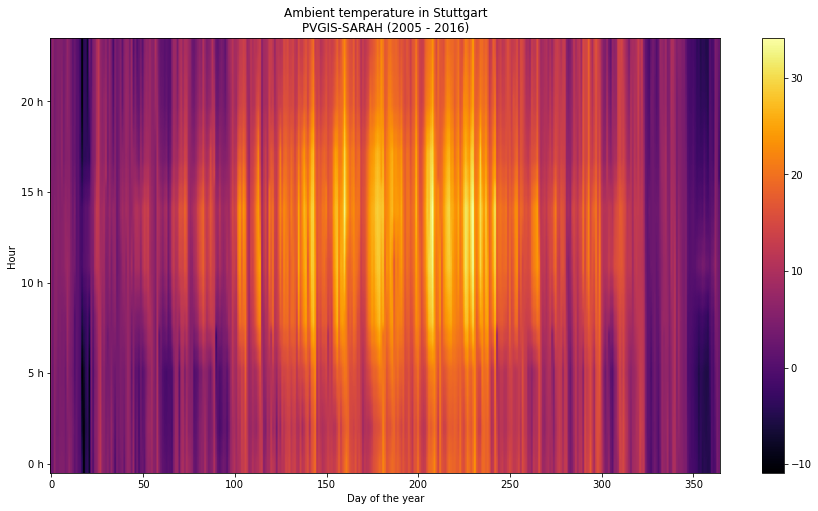

In [13]:
plt.figure(figsize=(15, 8))
plt.imshow(weather.temp_air.values.reshape(-1,24).T,
           aspect='auto',
           origin='lower', cmap='inferno')
plt.title('Ambient temperature in %s\n%s' % (LOCATION, weather_source))
plt.xlabel('Day of the year')
plt.ylabel('Hour')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%d h'))
plt.colorbar();

## Define system

In [14]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
# Get the module and inverter specifications from SAM
module = retrieve_sam('SandiaMod')['Canadian_Solar_CS5P_220M___2009_']
inverter = retrieve_sam('cecinverter')['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
temp_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

location = Location(LATITUDE, LONGITUDE, name=LOCATION,
                    altitude=ALTITUDE, tz=TIMEZONE)

system = PVSystem(module_parameters=module,
                  inverter_parameters=inverter,
                  temperature_model_parameters=temp_parameters,
                  surface_tilt=TILT,
                  surface_azimuth=AZIMUTH,
                  albedo = ALBEDO
                 )
mc = ModelChain(system, location, transposition_model='haydavies')
results = mc.run_model(weather)

## Global horizontal irradiance

In [15]:
irradiances = weather.ghi.resample('M').mean().to_frame()
irradiances['poa'] = mc.results.total_irrad.poa_global.resample('M').mean()

In [16]:
irradiances.index = irradiances.index.month_name()

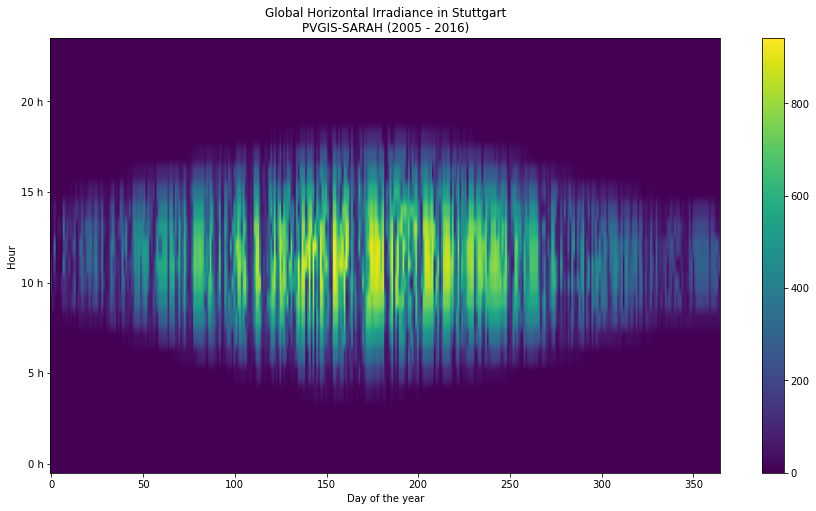

In [17]:
plt.figure(figsize=(15, 8))
plt.imshow(weather.ghi.values.reshape(-1,24).T,
           aspect='auto',
           origin='lower')
plt.title('Global Horizontal Irradiance in %s\n%s'% (LOCATION, weather_source))
plt.xlabel('Day of the year')
plt.ylabel('Hour')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%d h'))
plt.colorbar();

# Solar position

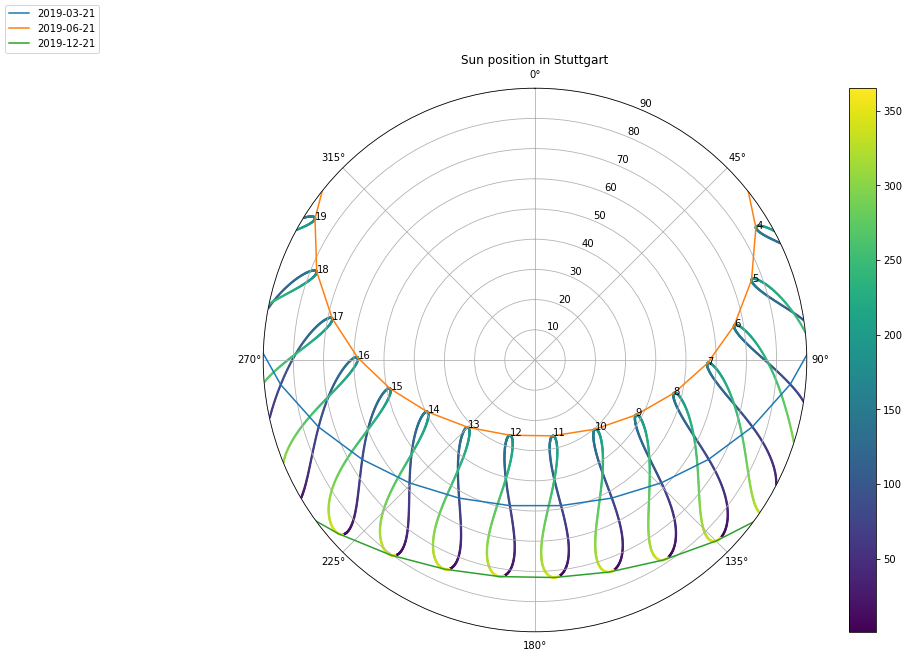

In [18]:
# Adapted from https://pvlib-python.readthedocs.io/en/stable/auto_examples/plot_sunpath_diagrams.html#polar-plot
from pvlib import solarposition
import pandas as pd
import numpy as np

solpos = mc.results.solar_position
# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

ax = plt.subplot(1, 1, 1, projection='polar')
# draw the analemma loops
points = ax.scatter(np.radians(solpos.azimuth), solpos.apparent_zenith,
                    s=2, label=None, c=solpos.index.dayofyear)
ax.figure.colorbar(points)

# draw hour labels
for hour in np.unique(solpos.index.hour):
    # choose label position by the smallest radius for each hour
    subset = solpos.loc[solpos.index.hour == hour, :]
    r = subset.apparent_zenith
    pos = solpos.loc[r.idxmin(), :]
    ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))

    
# draw individual days
for day_of_year in [80, 172, 355]: # should correspond to March 21st, June 21st and December 21st:
    solpos = mc.results.solar_position[mc.results.solar_position.index.dayofyear == day_of_year]
    solpos = solpos.loc[solpos['apparent_elevation'] > -20, :]

    label = solpos.index[0].strftime('%Y-%m-%d')
    ax.plot(np.radians(solpos.azimuth), solpos.apparent_zenith, label=label)

ax.figure.legend(loc='upper left')

# change coordinates to be like a compass
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)

plt.title("Sun position in %s" % LOCATION)

plt.show()

## Optimum tilt for given azimuth and location

In [19]:
tilts = range(91)
insolation_for_tilts = []
mount = system.arrays[0].mount
for tilt in tilts:
    #NOTE: Running a whole PV simulation just for POA irradiance isn't optimal. It requires fewer parameters, though.
    mount.surface_tilt = tilt
    mc.run_model(weather)
    print('.', end='')
    insolation_for_tilts.append(mc.results.total_irrad.poa_global.sum() / 1000)

# Reset mc back to defined tilt
mount.surface_tilt = TILT
mc.run_model(weather);

...........................................................................................

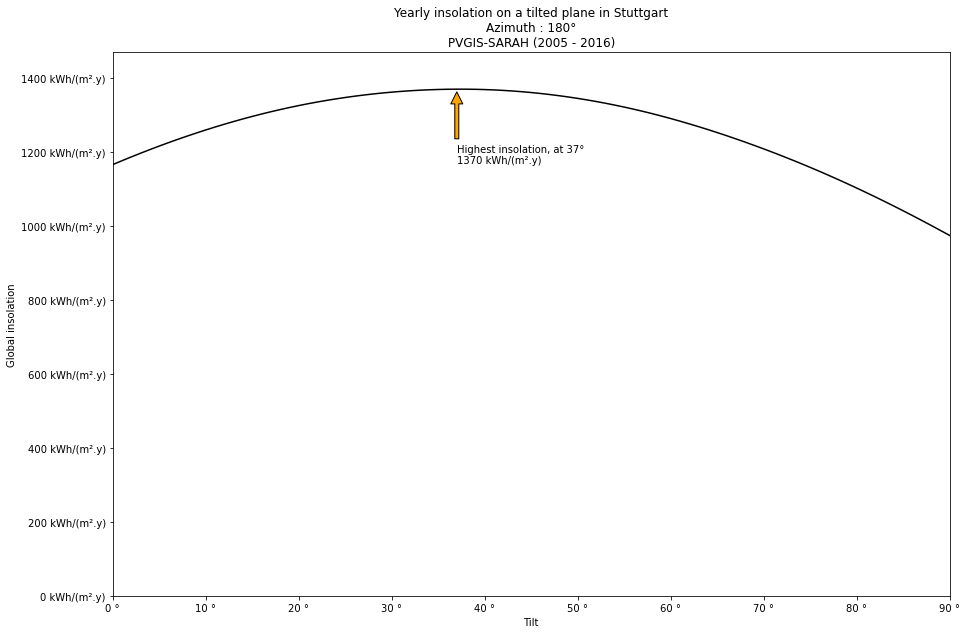

In [20]:
highest_insolation=max(insolation_for_tilts)
best_tilt = tilts[np.argmax(insolation_for_tilts)]
plt.plot(tilts, insolation_for_tilts, color='black')
plt.ylim(ymin=0, ymax=highest_insolation+100)
plt.xlim(xmin=0, xmax=90)
plt.xlabel('Tilt')
plt.ylabel('Global insolation')
plt.title("Yearly insolation on a tilted plane in %s\nAzimuth : %.0f°\n%s" % (LOCATION, AZIMUTH, weather_source))
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%d °'))
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%d kWh/(m².y)'))
plt.annotate('Highest insolation, at %.0f°\n%.0f kWh/(m².y)' % (best_tilt, highest_insolation),
             xy=(best_tilt, highest_insolation),
             xytext=(best_tilt, highest_insolation-200),
             arrowprops=dict(facecolor='orange', shrink=0.05)
            )
plt.show()

## Plane of array irradiance 

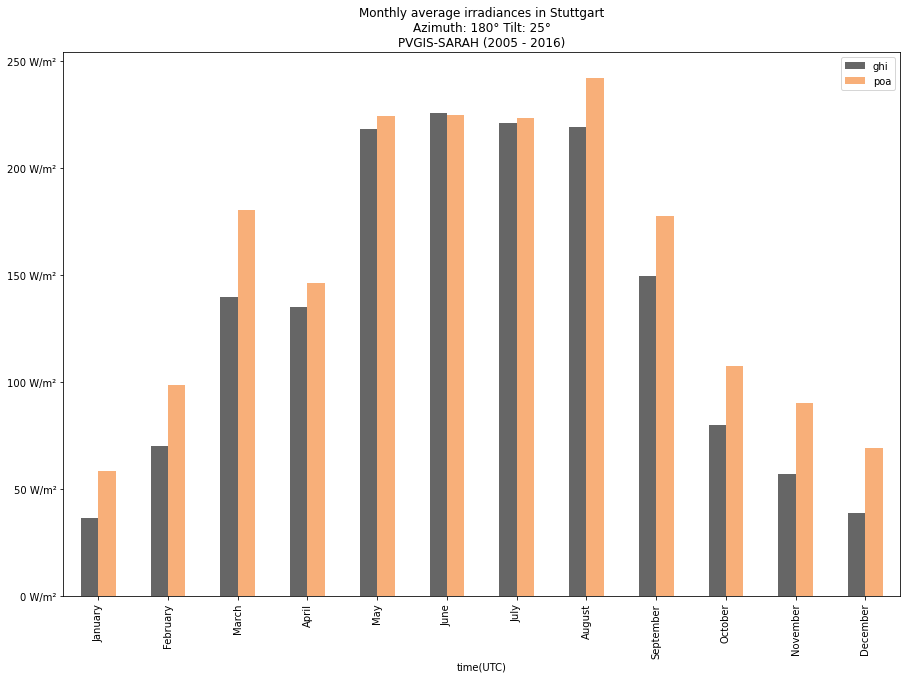

In [21]:
ax=irradiances.plot.bar(title='Monthly average irradiances in %s\nAzimuth: %.0f° Tilt: %.0f°\n%s' % (LOCATION, AZIMUTH, TILT, weather_source),
                     color=['black', '#f47b20'],
                     alpha=0.6);
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d W/m²'))

In [22]:
print("Average GHI irradiance in %s : %.1f W/m²" % (LOCATION, weather.ghi.mean()))
daily_temperatures = weather.temp_air.resample('D').mean()
print("Average POA irradiance in %s : %.1f W/m²" % (LOCATION, mc.results.total_irrad.poa_global.mean()))
print("Total GHI insolation in %s   : %.0f kWh/(m² . y)" % (LOCATION, weather.ghi.sum() / 1000))
print("Total POA insolation in %s   : %.0f kWh/(m² . y)" % (LOCATION, mc.results.total_irrad.poa_global.sum() / 1000))

Average GHI irradiance in Stuttgart : 133.0 W/m²
Average POA irradiance in Stuttgart : 153.9 W/m²
Total GHI insolation in Stuttgart   : 1165 kWh/(m² . y)
Total POA insolation in Stuttgart   : 1348 kWh/(m² . y)


In [23]:
# That's weird. POA seems too high!
  # Perez is even worse than HayDavies
  # Standard albedo is 0.25

In [24]:
print(system.arrays[0].albedo)

0.2


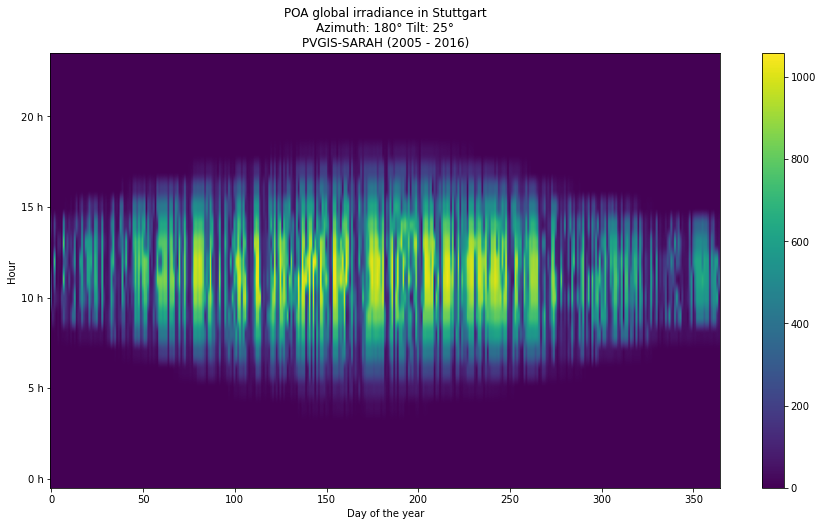

In [25]:
plt.figure(figsize=(15, 8))
plt.imshow(mc.results.total_irrad.poa_global.values.reshape(-1,24).T,
           aspect='auto',
           origin='lower')
plt.title('POA global irradiance in %s\nAzimuth: %.0f° Tilt: %.0f°\n%s' %
          (LOCATION, AZIMUTH, TILT, weather_source))
plt.xlabel('Day of the year')
plt.ylabel('Hour')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%d h'))
plt.colorbar();

## Albedo + Diffuse + Direct

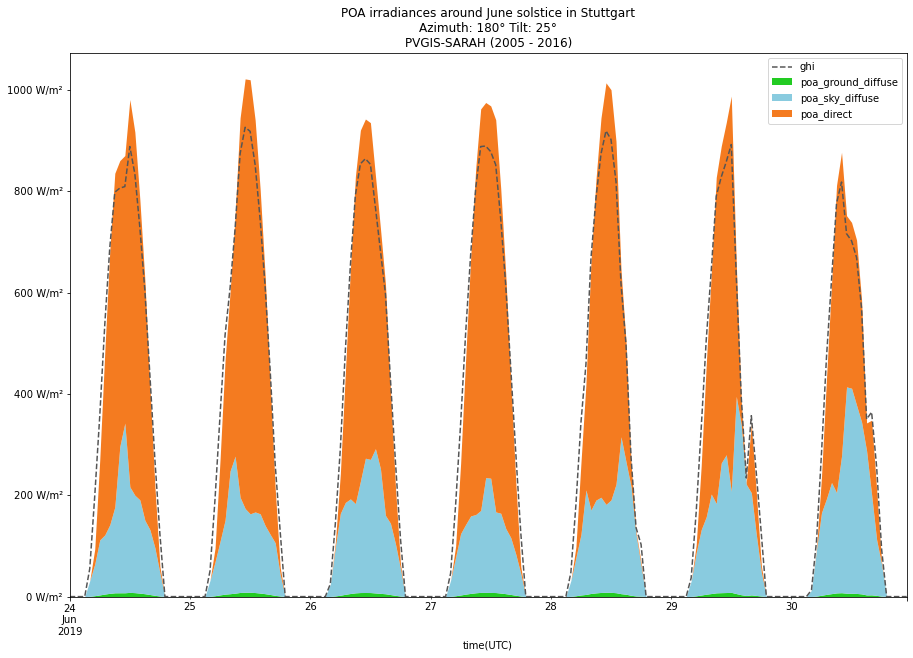

In [26]:
#TODO: DRY with december
ax = weather[weather.index.isocalendar().week == 26].ghi.plot(style='--', color='#555555', legend='GHI')
mc.results.total_irrad[mc.results.total_irrad.index.isocalendar().week == 26].plot.area(
    ax=ax,
    title='POA irradiances around June solstice in %s\nAzimuth: %.0f° Tilt: %.0f°\n%s' %
    (LOCATION, AZIMUTH, TILT, weather_source),
    y=['poa_ground_diffuse', 'poa_sky_diffuse', 'poa_direct'],
    color=["#22cb22", "#89cbdf", "#f47b20"],
    lw=0
)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d W/m²'))

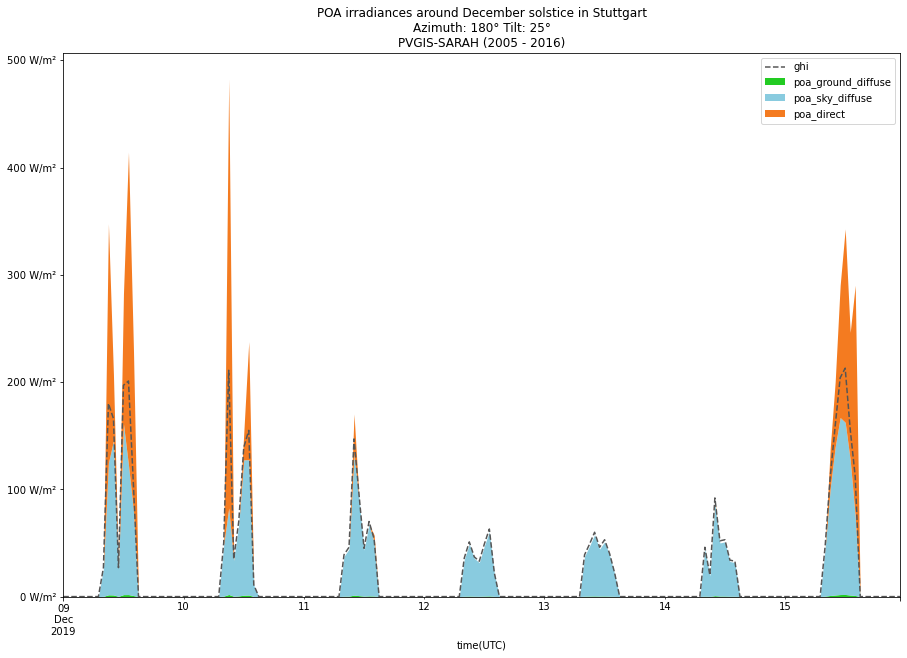

In [27]:
ax = weather[weather.index.isocalendar().week == 50].ghi.plot(style='--', color='#555555', legend='GHI')
mc.results.total_irrad[mc.results.total_irrad.index.isocalendar().week == 50].plot.area(
    ax=ax,
    title='POA irradiances around December solstice in %s\nAzimuth: %.0f° Tilt: %.0f°\n%s' %
    (LOCATION, AZIMUTH, TILT, weather_source),
    y=['poa_ground_diffuse', 'poa_sky_diffuse', 'poa_direct'],
    color=["#22cb22", "#89cbdf", "#f47b20"],
    lw=0
)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d W/m²'))

## Misc

In [28]:
i = mc.results.total_irrad

In [29]:
 all(np.isclose(i.poa_diffuse, i.poa_sky_diffuse + i.poa_ground_diffuse))

True

In [30]:
 all(np.isclose(i.poa_global, i.poa_direct + i.poa_sky_diffuse + i.poa_ground_diffuse))

True

In [31]:
mc.dc_model()

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [32]:
#TODO: Add I(V), P(V)

In [33]:
#TODO: Add eta inverter curve

In [34]:
#TODO: Check what's missing from insel report